Example: Let's evaluate the performance of this brain cancer segmentation

## Introduction

Given the following simplistic dataset:
```
imaging.png          # The image itself
mask_gt.png          # The ground truth mask encoded as png
mask_pd.A.npy        # Prediction A encoded as NumPy file
mask_pd.B.npy        # Prediction B encoded as NumPy file
```

First of all, we visualize all the image and masks.

Visualization: Image


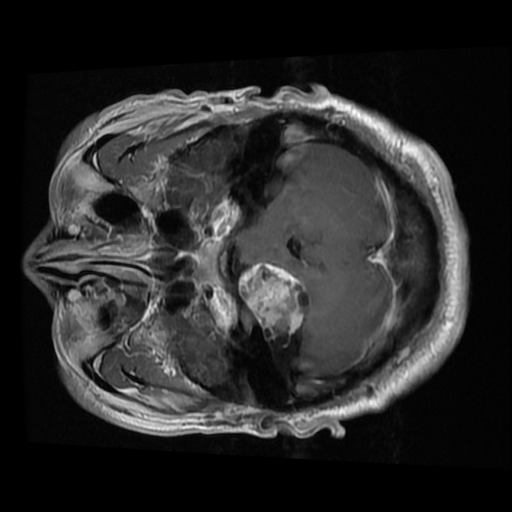

Visualization: Ground Truth Segmentation


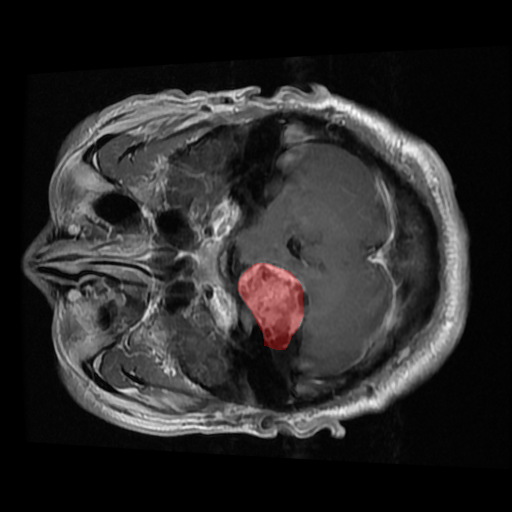

Visualization: Predicted Mask A Segmentation


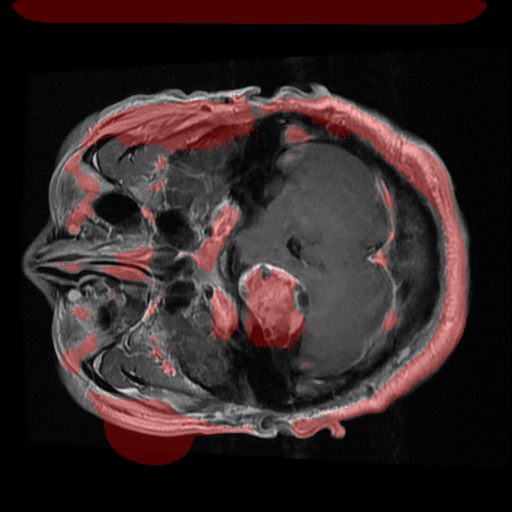

Visualization: Predicted Mask B Segmentation


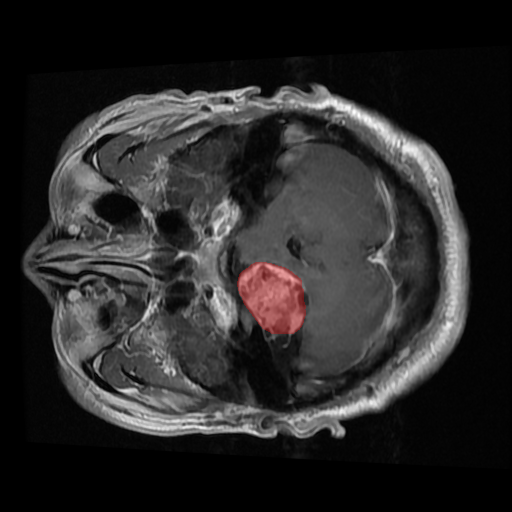

In [1]:
import numpy as np
from PIL import Image

# Here we define a visualization function for overlaying the mask on the image
def overlay_segmentation(img_rgb, seg):
    # Initialize segmentation in RGB
    shp = seg.shape
    seg_rgb = np.zeros((shp[0], shp[1], 3), dtype=np.int)
    # Set class to appropriate color
    seg_rgb[np.equal(seg, 1)] = [255, 0,   0]
    # Get binary array for places where an ROI lives
    segbin = np.greater(seg, 0)
    repeated_segbin = np.stack((segbin, segbin, segbin), axis=-1)
    # Weighted sum where there's a value to overlay
    alpha = 0.3
    img_overlayed = np.where(
        repeated_segbin,
        np.round(alpha*seg_rgb+(1-alpha)*img_rgb).astype(np.uint8),
        np.round(img_rgb).astype(np.uint8)
    )
    # Return final image with segmentation overlay
    return img_overlayed

# Visualizations
print("Visualization: Image")
pillow_image = Image.open("imaging.png")
image = np.asarray(pillow_image)
image_rgb = np.stack([image, image, image], axis=-1)
pillow_image.show()

print("Visualization: Ground Truth Segmentation")
pillow_gt = Image.open("mask_gt.png")
mask_gt = np.asarray(pillow_gt)
pillow_mask_gt = overlay_segmentation(image_rgb, mask_gt)

pillow_gt = Image.fromarray(pillow_mask_gt)
pillow_gt.show()

print("Visualization: Predicted Mask A Segmentation")
mask_pd_A_softmax_withChannel = np.load("mask_pd.A.npy")        # shape: 512x512x2x1 -> 512x512x2
mask_pd_A_softmax = np.squeeze(mask_pd_A_softmax_withChannel)   # shape: 512x512x2x1 -> 512x512x2
mask_pd_A = np.argmax(mask_pd_A_softmax, axis=-1)               # shape: 512x512x2 -> 512x512

pillow_mask_pd_A = overlay_segmentation(image_rgb, mask_pd_A)

pillow_pd_A = Image.fromarray(pillow_mask_pd_A)
pillow_pd_A.show()

print("Visualization: Predicted Mask B Segmentation")
mask_pd_B_softmax_withChannel = np.load("mask_pd.B.npy")        # shape: 512x512x2x1 -> 512x512x2
mask_pd_B_softmax = np.squeeze(mask_pd_B_softmax_withChannel)   # shape: 512x512x2x1 -> 512x512x2
mask_pd_B = np.argmax(mask_pd_B_softmax, axis=-1)               # shape: 512x512x2 -> 512x512

pillow_mask_pd_B = overlay_segmentation(image_rgb, mask_pd_B)

pillow_pd_B = Image.fromarray(pillow_mask_pd_B)
pillow_pd_B.show()

## Performance Evaluation

So, now let's assess the performance by multiple popular metrics for a state-of-the-art medical image segmentation evaluation.

Here, we use the proposed package: `miseval: a metric library for Medical Image Segmentation EVALuation`.

Source: https://github.com/frankkramer-lab/miseval

You can install it with `pip install miseval`.

In [2]:
# Summary: Our segmentation masks are all in a NumPy matrix format
print("Ground truth:", mask_gt.shape)
print("Prediction A:", mask_pd_A.shape)
print("Prediction B:", mask_pd_B.shape)

Ground truth: (512, 512)
Prediction A: (512, 512)
Prediction B: (512, 512)


In [3]:
# First and most important step:
# -> import the evaluate interface from the miseval library
from miseval import evaluate

# Now, we just call the evaluate interface with the desired metric
dice_A = evaluate(mask_gt, mask_pd_A, metric="Dice")
dice_B = evaluate(mask_gt, mask_pd_B, metric="Dice")
print("Dice Similarity Coefficient for A:", dice_A)
print("Dice Similarity Coefficient for B:", dice_B)

Dice Similarity Coefficient for A: 0.12811184237419776
Dice Similarity Coefficient for B: 0.9114252366748801


In [4]:
# Now, let's compute a more complex metric like the Average Hausdorff Distance
ahd_A = evaluate(mask_gt, mask_pd_A, metric="AverageHausdorffDistance")
ahd_B = evaluate(mask_gt, mask_pd_B, metric="AverageHausdorffDistance")
print("AHD for A:", ahd_A)
print("AHD for B:", ahd_B)

AHD for A: 354.18921496849674
AHD for B: 16.0


In [5]:
# Can we also compute multiple metrics at once?
metric_list = ["DSC", "IoU", "Accuracy", "Sensitivity", "Specificity"]
results = []
for m in metric_list:
    res = evaluate(mask_gt, mask_pd_B, metric=m)
    results.append(res)
    
for i in range(0, len(metric_list)):
    print(metric_list[i], results[i])

DSC 0.9114252366748801
IoU 0.8372647128901597
Accuracy 0.9973945617675781
Sensitivity 0.889620253164557
Specificity 0.9990433549966304


## Computing the Area under the ROC Curve

For computing the AUROC (AUC), we can either compute it based on an estimation formula (trapezoid) or with the softmax values.

In [6]:
# Trapezoid estimation
auc_a = evaluate(mask_gt, mask_pd_A, metric="AUC")
auc_b = evaluate(mask_gt, mask_pd_B, metric="AUC")
print(auc_a, auc_b)

# ROC / softmax computation
from miseval import calc_AUC_probability

print(mask_pd_A_softmax.shape)
print(mask_pd_B_softmax.shape)

auc_a = calc_AUC_probability(mask_gt, mask_pd_A_softmax)
auc_b = calc_AUC_probability(mask_gt, mask_pd_B_softmax)
print(auc_a, auc_b)

0.8156806416684226 0.9443318040805937
(512, 512, 2)
(512, 512, 2)
0.8584014816451921 0.9464971339870726


The trapezoid estimation is quite close, but the softmax computation is the gold-standard.

## Final words

Thank you for your interest in using miseval. :)

Cheers,
Dominik Müller